# Guided Project: Task 2A: Image-Caption Retrieval with CLIP

This notebook implements image-to-caption retrieval using CLIP (Contrastive Language-Image Pretraining).

## Names
1. Diego Bermudez Sierra - dabermud@andrew.cmu.edu
2. Santiago Bolaños Vega - sbolaosv@andrew.cmu.edu

## Objectives:
1. Load pretrained CLIP model from Hugging Face
2. Compute embeddings for images and captions
3. Perform image-to-caption retrieval using cosine similarity
4. Evaluate retrieval performance with multiple metrics:
   - Recall@K (instance-level and class-aware)
   - BERTScore
   - CLIPScore
   - Mean Average Precision (MAP)

## AI Acknowledgement
This task was completed with assistance from an AI coding assistant (Auto, powered by Cursor) that helped implement and debug the code for Task 2A: Image-Caption Retrieval with CLIP. The assistant provided guidance on environment setup, resolved PyTorch CUDA compatibility issues, fixed CLIP model loading with safetensors support, corrected data loading functions to properly parse the captions.txt file format, and helped configure the GPU environment on Bridges2. All code implementations, debugging, and final solutions were developed collaboratively through iterative problem-solving sessions.

In [1]:
# %%
config = {
    "data_root": "/ocean/projects/cis250019p/gandotra/11785-gp-eeg",
    "captions_path": "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt",
    "image_dirs": [
        "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images",
        "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/All_images",
    ],
    "clip_model_name": "openai/clip-vit-base-patch32",
    "batch_size": 32,
    "bert_sample_size": 1000,
    "top_k": 5,
}

## 1. Set-up: Installation and Imports

In [2]:
# %%
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import CLIPModel, CLIPProcessor

# --- Add project paths so we can import both EEG and CLIP utilities ---

# Path to 4-eeg-classifiers (for dataset_builder.load_captions)
sys.path.append("/jet/home/bermudez/exploring-eeg/4-eeg-classifiers")

# Path to this folder (CLIP utilities live in utils_clip/)
sys.path.append("/jet/home/bermudez/exploring-eeg/5-caption-retrieval")

# --- Import our modular CLIP helpers ---
from utils_clip.caption_loader import load_captions_for_clip
from utils_clip.image_resolver import build_image_caption_df
from utils_clip.clip_embedding import (
    compute_image_embeddings,
    compute_text_embeddings,
    batch_retrieve_captions,
)
from utils_clip.retrieval_metrics import (
    recall_at_k_instance,
    recall_at_k_class_aware,
    map_caption_level,
    map_class_aware,
    map_per_class,
    bertscore_top1,
)
from utils_clip.retrieval_visuals import (
    plot_clipscore_distribution,
    visualize_retrieval_examples,
)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. CLIP Model Loading


In [3]:
# %%
model_name = config["clip_model_name"]
print(f"Loading CLIP model: {model_name}")

clip_model = CLIPModel.from_pretrained(
    model_name,
    use_safetensors=True,   
    local_files_only=False,
    torch_dtype=torch.float32
).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_name)
clip_model.eval()

print("CLIP model loaded successfully!")
print(f"Image encoder: {clip_model.vision_model.__class__.__name__}")
print(f"Text encoder: {clip_model.text_model.__class__.__name__}")
print(f"Embedding dimension: {clip_model.config.projection_dim}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading CLIP model: openai/clip-vit-base-patch32


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded successfully!
Image encoder: CLIPVisionTransformer
Text encoder: CLIPTextTransformer
Embedding dimension: 512


## 2. Data Loading Functions

We need to:

1. **Load captions and metadata** from `captions.txt` (image names, captions, categories)
2. **Resolve image file paths** by searching image directories for matching filenames
3. **Build image-caption pairs** mapping each image path to its caption and category
4. **Handle missing files** by filtering out images that cannot be located

In [4]:
DATA_ROOT = Path(config["data_root"])
CAPTIONS_PATH = Path(config["captions_path"])
IMAGE_DIRS = [Path(p) for p in config["image_dirs"]]

print("Checking dataset paths...")
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("CAPTIONS_PATH exists:", CAPTIONS_PATH.exists())
for d in IMAGE_DIRS:
    print(f"{d} exists:", d.exists())

# --- Load captions via EEG helper ---
captions_df = load_captions_for_clip(CAPTIONS_PATH)
print(f"\nLoaded captions: {len(captions_df)}")
print(captions_df.head())

# --- Resolve image paths ---
dataset_df = build_image_caption_df(captions_df, IMAGE_DIRS)
print(f"\nValid image–caption pairs: {len(dataset_df)}")
print("Categories:", dataset_df["category"].nunique())
print(dataset_df.head())

Checking dataset paths...
DATA_ROOT exists: True
CAPTIONS_PATH exists: True
/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images exists: True
/ocean/projects/cis250019p/gandotra/11785-gp-eeg/All_images exists: False
Loaded 9825 caption entries from captions.txt

Loaded captions: 9825
        image_name                                      caption category
0   n02835271_1031  Tandem bicycle parked beside a wooden fence  bicycle
1  n02835271_10424    Tandem bicycle leaning against brick wall  bicycle
2  n02835271_10469        Bicycle leaning against a wooden post  bicycle
3   n02835271_1055    Tandem bicycle parked beside green bushes  bicycle
4  n02835271_10778        Tandem bicycle parked by a brick wall  bicycle


Resolving image paths: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9825/9825 [00:00<00:00, 31039.13it/s]


Valid image–caption pairs: 9825
Categories: 20
        image_name                                      caption category  \
0   n02835271_1031  Tandem bicycle parked beside a wooden fence  bicycle   
1  n02835271_10424    Tandem bicycle leaning against brick wall  bicycle   
2  n02835271_10469        Bicycle leaning against a wooden post  bicycle   
3   n02835271_1055    Tandem bicycle parked beside green bushes  bicycle   
4  n02835271_10778        Tandem bicycle parked by a brick wall  bicycle   

                                          image_path  
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
3  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
4  /ocean/projects/cis250019p/gandotra/11785-gp-e...  


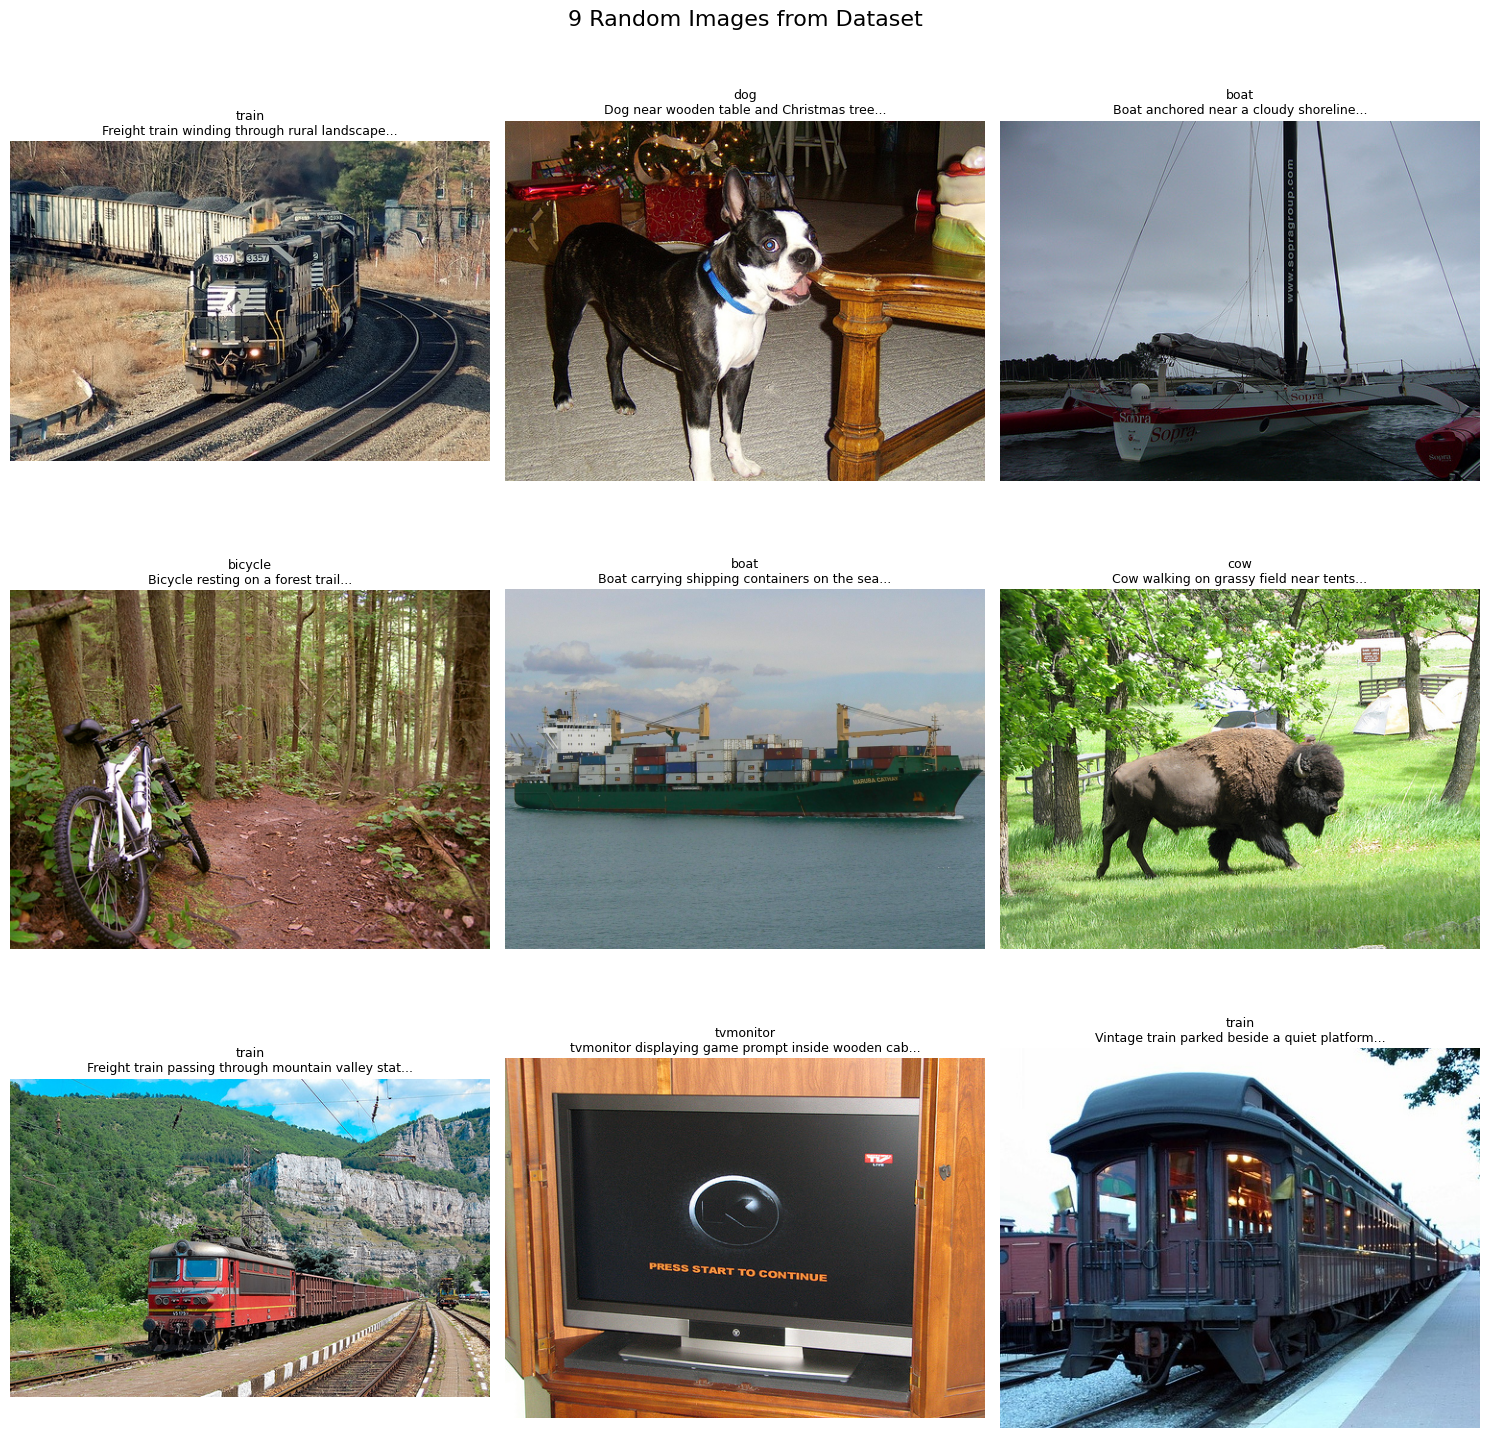

In [5]:
# %% [markdown]
# ### 2.1 Quick Visual Inspection (Random 3×3 Grid)

# %%
if len(dataset_df) >= 9:
    sample_df = dataset_df.sample(9, random_state=42).reset_index(drop=True)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle("9 Random Images from Dataset", fontsize=16, y=0.995)

    for idx, row in sample_df.iterrows():
        ax = axes[idx // 3, idx % 3]
        try:
            img = plt.imread(row["image_path"])
            ax.imshow(img)
            ax.set_title(f"{row['category']}\n{row['caption'][:50]}...", fontsize=9, pad=5)
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{e}", ha="center", va="center", fontsize=8)
            ax.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough valid images to show grid. Found {len(dataset_df)}.")

## 4. Compute Embeddings

We'll compute embeddings for all images and captions in batches for efficiency.


In [6]:
# %%
print("Computing image embeddings...")
image_embeddings = compute_image_embeddings(
    model=clip_model,
    processor=clip_processor,
    image_paths=dataset_df["image_path"].tolist(),
    batch_size=config["batch_size"],
    device=device,
)

print("Computing text embeddings...")
text_embeddings = compute_text_embeddings(
    model=clip_model,
    processor=clip_processor,
    texts=dataset_df["caption"].tolist(),
    batch_size=config["batch_size"],
    device=device,
)

print("\nImage embeddings shape:", image_embeddings.shape)
print("Text embeddings shape:", text_embeddings.shape)

# Move to GPU tensors for retrieval / metrics
image_embeddings_gpu = image_embeddings.to(device)
text_embeddings_gpu = text_embeddings.to(device)

Computing image embeddings...


Image embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [01:23<00:00,  3.68it/s]


Computing text embeddings...


Text embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:02<00:00, 146.81it/s]


Image embeddings shape: torch.Size([9825, 512])
Text embeddings shape: torch.Size([9825, 512])


## 5. Image-to-Caption Retrieval

Implement retrieval using cosine similarity.


In [7]:
top_k = config["top_k"]

retrieved_indices, retrieved_scores, similarity_matrix = batch_retrieve_captions(
    image_embs=image_embeddings_gpu,
    text_embs=text_embeddings_gpu,
    k=top_k,
)

print(f"Retrieved top-{top_k} captions for {len(retrieved_indices)} images.")

Retrieved top-5 captions for 9825 images.


## 6. Evaluation Metrics

Implement all required evaluation metrics.


In [8]:
# %%
# Ground truth: 1-to-1 mapping image i ↔ caption i
ground_truth_indices = np.arange(len(dataset_df))
categories = dataset_df["category"].values

print("Computing Recall@K metrics...")
recall_instance = recall_at_k_instance(
    retrieved_idx=retrieved_indices,
    gt_idx=ground_truth_indices,
    k_values=(1, 3, 5),
)

recall_class_aware = recall_at_k_class_aware(
    retrieved_idx=retrieved_indices,
    gt_idx=ground_truth_indices,
    categories=categories,
    k_values=(1, 3, 5),
)

print("\n=== Recall Metrics ===")
for k, score in recall_instance.items():
    print(f"{k}: {score:.4f}")
for k, score in recall_class_aware.items():
    print(f"{k}: {score:.4f}")

print("\nComputing MAP metrics...")
map_caption = map_caption_level(similarity_matrix, ground_truth_indices)
map_class_aware = map_class_aware(similarity_matrix, ground_truth_indices, categories)
map_per_class = map_per_class(similarity_matrix, ground_truth_indices, categories)

print("\n=== MAP Metrics ===")
print(f"Caption-level MAP:  {map_caption:.4f}")
print(f"Class-aware MAP:    {map_class_aware:.4f}")
print("\nPer-class MAP:")
for cat, score in sorted(map_per_class.items()):
    print(f"  {cat:20s}: {score:.4f}")

Computing Recall@K metrics...

=== Recall Metrics ===
Recall@1: 0.1982
Recall@3: 0.3270
Recall@5: 0.3950
Class-aware Recall@1: 0.9699
Class-aware Recall@3: 0.9825
Class-aware Recall@5: 0.9851

Computing MAP metrics...

=== MAP Metrics ===
Caption-level MAP:  0.2980
Class-aware MAP:    0.8305

Per-class MAP:
  aeroplane           : 0.1832
  bicycle             : 0.2737
  bird                : 0.3845
  boat                : 0.1558
  bottle              : 0.4389
  bus                 : 0.2013
  car                 : 0.3972
  cat                 : 0.4781
  chair               : 0.3681
  cow                 : 0.1949
  diningtable         : 0.1902
  dog                 : 0.4982
  flower              : 0.1442
  horse               : 0.2014
  motorbike           : 0.3002
  person              : 0.5480
  sheep               : 0.1208
  sofa                : 0.3457
  train               : 0.2751
  tvmonitor           : 0.2559


## 7. Semantic Metrics: BERTScore and CLIPScore


In [9]:
# %%
# --- CLIPScore: similarity between image and retrieved caption (top-1) ---
clip_scores = []
for i, gt_idx in enumerate(ground_truth_indices):
    ret_idx = retrieved_indices[i, 0]
    sim = (image_embeddings_gpu[i:i+1] @ text_embeddings_gpu[ret_idx:ret_idx+1].T).item()
    clip_scores.append(sim)
clip_scores = np.array(clip_scores)

print("CLIPScore — top-1 retrieved caption:")
print(f"  Mean: {clip_scores.mean():.4f}, Std: {clip_scores.std():.4f}")
print(f"  Min:  {clip_scores.min():.4f}, Max: {clip_scores.max():.4f}")

# --- BERTScore: semantic similarity between retrieved captions and ground truth ---

# Build lists of candidate (retrieved) and reference (ground truth) captions
retrieved_captions_top1 = [
    dataset_df.iloc[retrieved_indices[i, 0]]["caption"]
    for i in range(len(ground_truth_indices))
]
ground_truth_captions = dataset_df["caption"].tolist()

# Sample subset (can be large & slow)
N = len(ground_truth_captions)
sample_size = min(config["bert_sample_size"], N)
sample_idx = np.random.choice(N, size=sample_size, replace=False)

bert_scores = bertscore_top1(
    retrieved_captions=retrieved_captions_top1,
    gt_captions=ground_truth_captions,
    sample_idx=sample_idx,
    device=device,
)

print("\nBERTScore F1 (top-1 retrieved vs ground truth):")
print(f"  Mean: {bert_scores.mean():.4f}, Std: {bert_scores.std():.4f}")
print(f"  High similarity rate (F1 > 0.7): {(bert_scores > 0.7).mean():.4f}")

CLIPScore — top-1 retrieved caption:
  Mean: 0.3223, Std: 0.0237
  Min:  0.2425, Max: 0.4579


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore F1 (top-1 retrieved vs ground truth):
  Mean: 0.9248, Std: 0.0469
  High similarity rate (F1 > 0.7): 1.0000


## 8. Analysis and Visualization


Analyzing CLIPScore distribution...

Matched pairs — Mean: 0.3021, Std: 0.0303
Mismatched pairs — Mean: 0.1398, Std: 0.0412


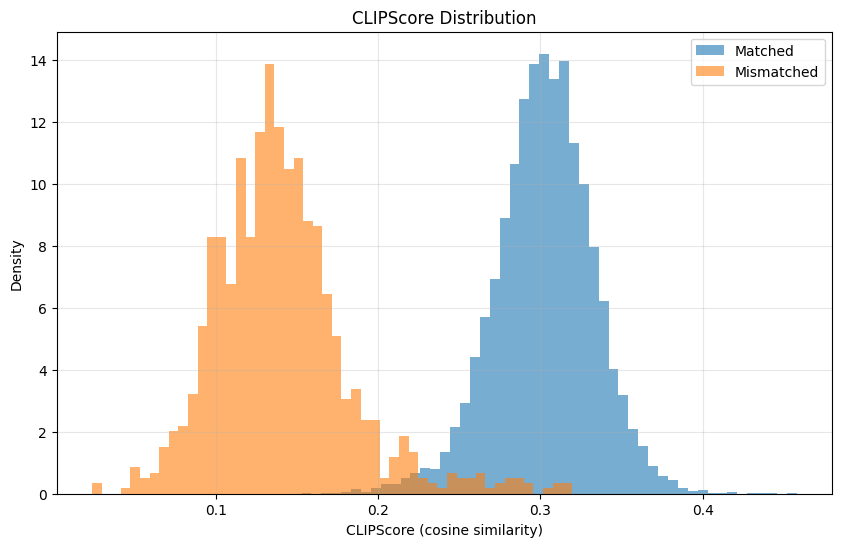

In [10]:
# %%
print("Analyzing CLIPScore distribution...")

# Matched scores: image i vs its ground-truth caption i
matched_scores = []
for i, gt_idx in enumerate(ground_truth_indices):
    sim = (image_embeddings_gpu[i:i+1] @ text_embeddings_gpu[gt_idx:gt_idx+1].T).item()
    matched_scores.append(sim)
matched_scores = np.array(matched_scores)

# Mismatched scores: random negative captions
mismatched_scores = []
max_samples = min(1000, len(ground_truth_indices))
for i in range(max_samples):
    img_emb = image_embeddings_gpu[i:i+1]
    # choose a caption index != ground truth
    neg_idx = np.random.randint(0, len(text_embeddings_gpu))
    if neg_idx == ground_truth_indices[i]:
        neg_idx = (neg_idx + 1) % len(text_embeddings_gpu)
    txt_emb = text_embeddings_gpu[neg_idx:neg_idx+1]
    sim = (img_emb @ txt_emb.T).item()
    mismatched_scores.append(sim)
mismatched_scores = np.array(mismatched_scores)

print(f"\nMatched pairs — Mean: {matched_scores.mean():.4f}, Std: {matched_scores.std():.4f}")
print(f"Mismatched pairs — Mean: {mismatched_scores.mean():.4f}, Std: {mismatched_scores.std():.4f}")

plot_clipscore_distribution(matched_scores, mismatched_scores)

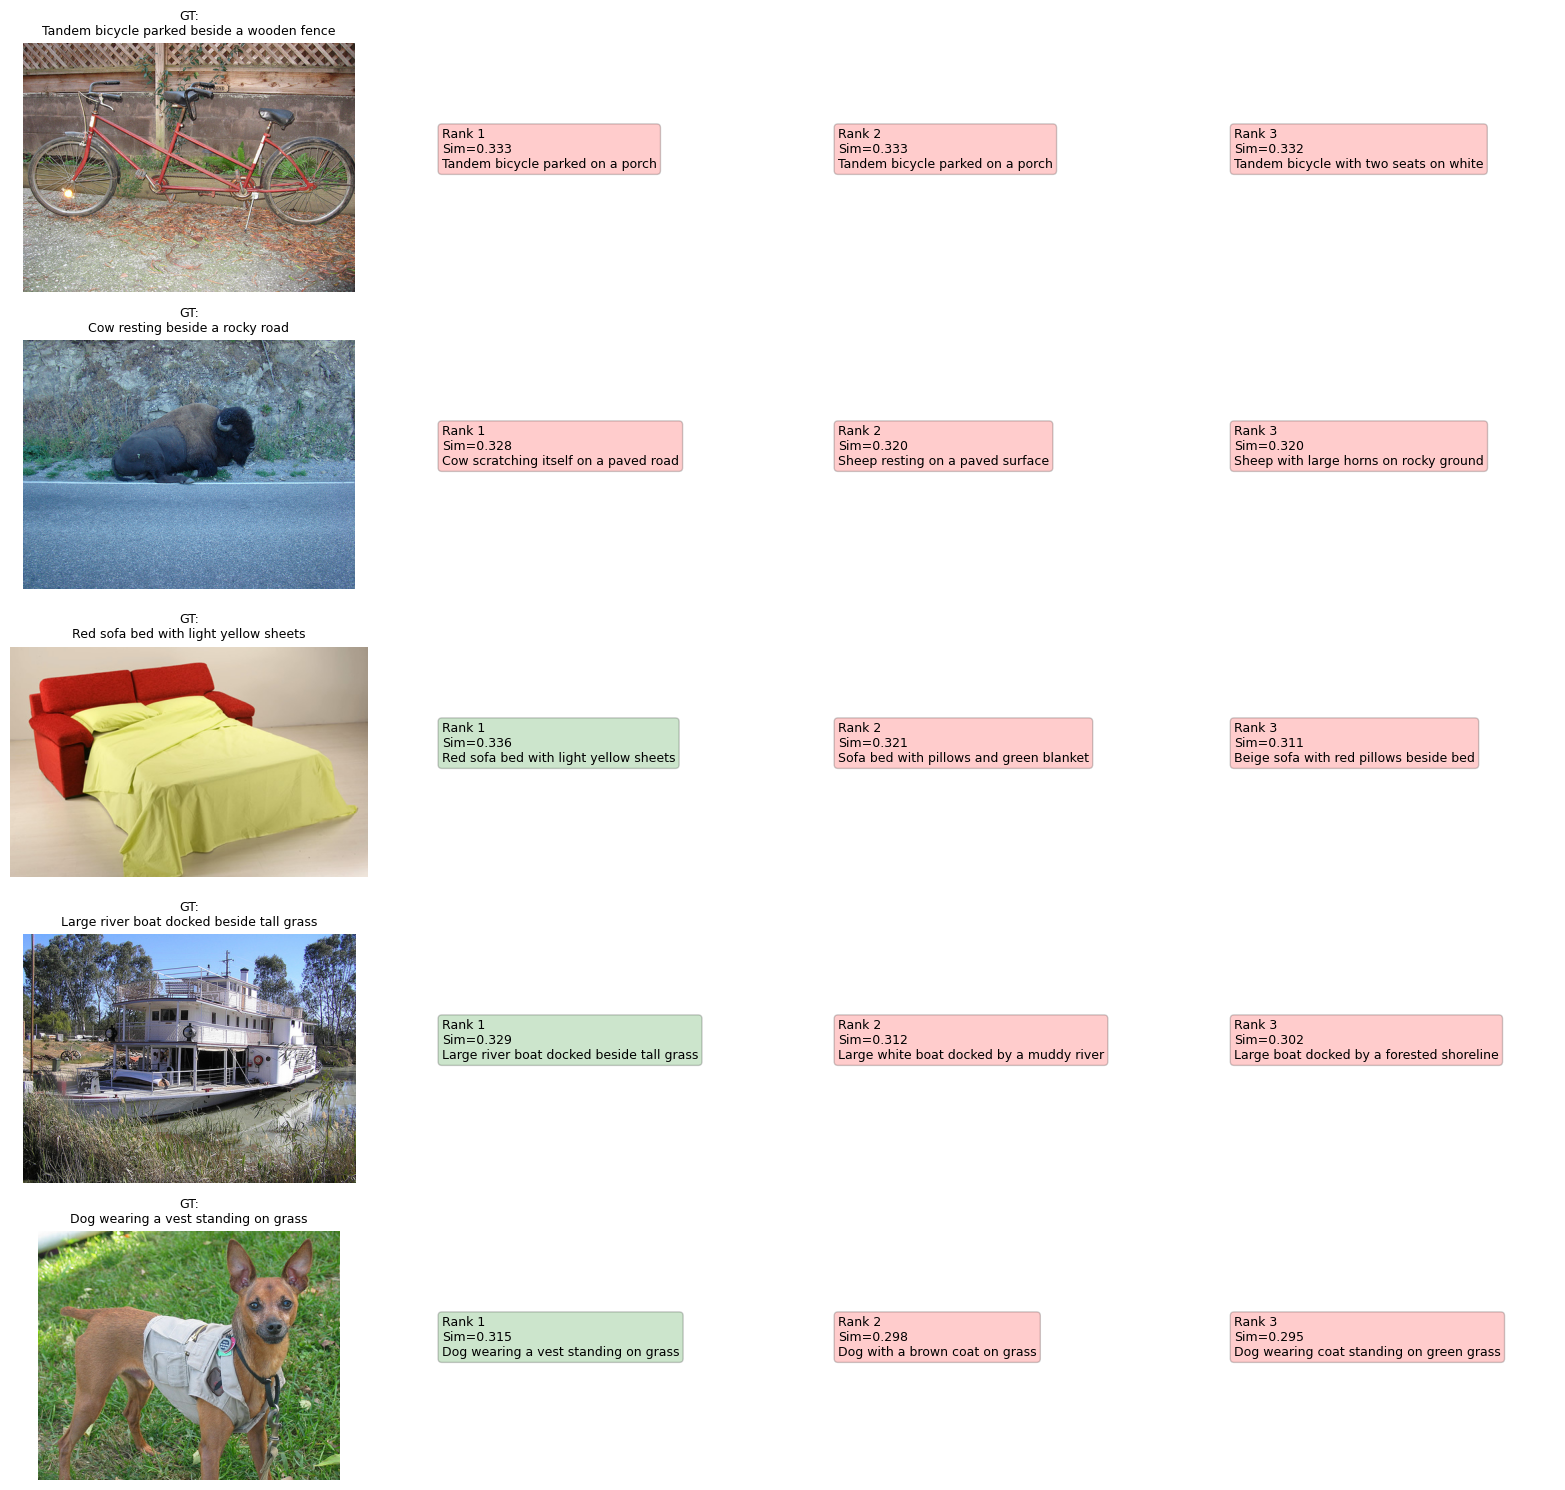

In [11]:
# %%
# You can adjust num_examples and top_k for nicer plots
visualize_retrieval_examples(
    df=dataset_df,
    retrieved_idx=retrieved_indices,
    img_embs=image_embeddings_gpu,
    txt_embs=text_embeddings_gpu,
    num_examples=5,
    top_k=3,
)

## 9. Summary Report

Compile all results into a summary.


In [12]:
# %%
print("=" * 60)
print("TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP — RESULTS SUMMARY")
print("=" * 60)

print("\n1. RETRIEVAL METRICS (Recall@K)")
print("-" * 60)
for k, score in recall_instance.items():
    print(f"  {k:25s}: {score:.4f}")
for k, score in recall_class_aware.items():
    print(f"  {k:25s}: {score:.4f}")

print("\n2. MEAN AVERAGE PRECISION (MAP)")
print("-" * 60)
print(f"  Caption-level MAP:         {map_caption:.4f}")
print(f"  Class-aware MAP:           {map_class_aware:.4f}")

print("\n3. SEMANTIC METRICS")
print("-" * 60)
print(f"  CLIPScore (top-1) mean:    {clip_scores.mean():.4f} ± {clip_scores.std():.4f}")
print(f"  Matched CLIPScore mean:    {matched_scores.mean():.4f} ± {matched_scores.std():.4f}")
print(f"  Mismatched CLIPScore mean: {mismatched_scores.mean():.4f} ± {mismatched_scores.std():.4f}")
print(f"  BERTScore F1 mean:         {bert_scores.mean():.4f} ± {bert_scores.std():.4f}")
print(f"  High similarity rate (>0.7): {(bert_scores > 0.7).mean():.4f}")

print("\n4. PER-CLASS MAP")
print("-" * 60)
for cat, score in sorted(map_per_class.items()):
    print(f"  {str(cat):20s}: {score:.4f}")

print("\n" + "=" * 60)
print("Analysis:")
print("-" * 60)
print(f"• Instance-level Recall@1: {recall_instance['Recall@1']:.2%} — CLIP retrieves")
print(f"  the exact ground-truth caption for {recall_instance['Recall@1']:.2%} of images.")
print(f"• Class-aware Recall@5: {recall_class_aware['Class-aware Recall@5']:.2%} — CLIP")
print(f"  retrieves a caption from the same category for {recall_class_aware['Class-aware Recall@5']:.2%} of images.")
print(f"• CLIPScore separation: {(matched_scores.mean() - mismatched_scores.mean()):.4f} difference")
print("  between matched and mismatched pairs shows how well CLIP separates true vs false pairs.")
print("=" * 60)

TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP — RESULTS SUMMARY

1. RETRIEVAL METRICS (Recall@K)
------------------------------------------------------------
  Recall@1                 : 0.1982
  Recall@3                 : 0.3270
  Recall@5                 : 0.3950
  Class-aware Recall@1     : 0.9699
  Class-aware Recall@3     : 0.9825
  Class-aware Recall@5     : 0.9851

2. MEAN AVERAGE PRECISION (MAP)
------------------------------------------------------------
  Caption-level MAP:         0.2980
  Class-aware MAP:           0.8305

3. SEMANTIC METRICS
------------------------------------------------------------
  CLIPScore (top-1) mean:    0.3223 ± 0.0237
  Matched CLIPScore mean:    0.3021 ± 0.0303
  Mismatched CLIPScore mean: 0.1398 ± 0.0412
  BERTScore F1 mean:         0.9248 ± 0.0469
  High similarity rate (>0.7): 1.0000

4. PER-CLASS MAP
------------------------------------------------------------
  aeroplane           : 0.1832
  bicycle             : 0.2737
  bird                